## Load and Examine Data

In [1]:
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.gridspec as gridspec

In [20]:
import tflearn.datasets.oxflower17 as oxflower17
X, Y = oxflower17.load_data(one_hot=True, resize_pics=(64,64))

Starting to parse images...
Parsing Done!


In [4]:
Y[:5]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.]])

In [21]:
print X.shape
print Y.shape

(1360, 64, 64, 3)
(1360, 17)


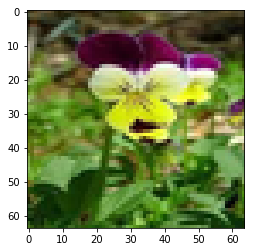

In [22]:
plt.imshow(X[30])

## GAN

In [23]:
def plot(samples):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(10, 10)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(64, 64, 3))

    return fig



In [33]:
mb_size = 16
X = X.reshape([-1, 12288])
def xavier_init(size):
    return tf.random_normal(shape=size, stddev=(1. / tf.sqrt(size[0] / 2.)))

def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

# Discriminator Net
X_ph = tf.placeholder(tf.float32, shape=[None, 12288], name='X')
#X_tf = tf.convert_to_tensor(X, tf.float32)
#tf.reshape(X_tf, [-1, 2352])
#X_mb = tf.train.batch([X_ph], mb_size, enqueue_many = True)

D_W1 = tf.Variable(xavier_init([12288, 128]), name='D_W1')
D_b1 = tf.Variable(tf.zeros(shape=[128]), name='D_b1')

D_W2 = tf.Variable(xavier_init([128, 1]), name='D_W2')
D_b2 = tf.Variable(tf.zeros(shape=[1]), name='D_b2')

theta_D = [D_W1, D_W2, D_b1, D_b2]

# Generator Net
Z_ph = tf.placeholder(tf.float32, shape=[None, 100], name='Z')

G_W1 = tf.Variable(xavier_init([100, 1024]), name='G_W1')
G_b1 = tf.Variable(tf.zeros(shape=[1024]), name='G_b1')

G_W2 = tf.Variable(xavier_init([1024, 12288]), name='G_W2')
G_b2 = tf.Variable(tf.zeros(shape=[12288]), name='G_b2')

theta_G = [G_W1, G_W2, G_b1, G_b2]

G_sample = generator(Z_ph)
D_real, D_logit_real = discriminator(X_ph)
D_fake, D_logit_fake = discriminator(G_sample)

D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
G_loss = -tf.reduce_mean(tf.log(D_fake))

# Only update D(X)'s parameters, so var_list = theta_D
D_solver = tf.train.AdamOptimizer(0.00005).minimize(D_loss, var_list=theta_D)
# Only update G(X)'s parameters, so var_list = theta_G
G_solver = tf.train.AdamOptimizer(0.0002).minimize(G_loss, var_list=theta_G)

def sample_Z(m, n):
    '''Uniform prior for G(Z)'''
    return np.random.uniform(-1., 1., size=[m, n])



Iter: 0
D loss: 1.623
G_loss: 0.3336
()


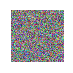

(0, 12288)
16
(16, 12288)
Iter: 100
D loss: 1.16
G_loss: 0.6372
()


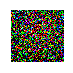

(0, 12288)
16
(16, 12288)
Iter: 200
D loss: 2.092
G_loss: 0.5584
()


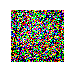

(0, 12288)
16
(16, 12288)
Iter: 300
D loss: 2.924
G_loss: 0.5561
()


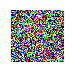

(0, 12288)
16
(16, 12288)
Iter: 400
D loss: 1.391
G_loss: 0.9136
()


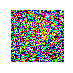

(0, 12288)
16
(16, 12288)
Iter: 500
D loss: 1.789
G_loss: 0.8937
()


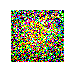

(0, 12288)
16
(16, 12288)
(0, 12288)
16
(16, 12288)
Iter: 600
D loss: 0.8901
G_loss: 1.312
()


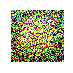

(0, 12288)
16
(16, 12288)
Iter: 700
D loss: 0.9785
G_loss: 1.207
()


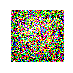

(0, 12288)
16
(16, 12288)
Iter: 800
D loss: 0.765
G_loss: 1.464
()


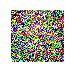

(0, 12288)
16
(16, 12288)
Iter: 900
D loss: 1.14
G_loss: 1.08
()


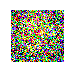

(0, 12288)
16
(16, 12288)
Iter: 1000
D loss: 0.7864
G_loss: 1.433
()


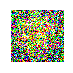

(0, 12288)
16
(16, 12288)
(0, 12288)
16
(16, 12288)
Iter: 1100
D loss: 1.09
G_loss: 1.185
()


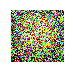

(0, 12288)
16
(16, 12288)
Iter: 1200
D loss: 0.9878
G_loss: 1.434
()


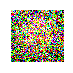

(0, 12288)
16
(16, 12288)
Iter: 1300
D loss: 1.078
G_loss: 1.223
()


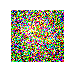

(0, 12288)
16
(16, 12288)
Iter: 1400
D loss: 0.7439
G_loss: 1.475
()


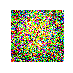

(0, 12288)
16
(16, 12288)
Iter: 1500
D loss: 0.9349
G_loss: 1.277
()


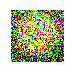

(0, 12288)
16
(16, 12288)
(0, 12288)
16
(16, 12288)
Iter: 1600
D loss: 0.6074
G_loss: 1.713
()


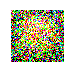

(0, 12288)
16
(16, 12288)
Iter: 1700
D loss: 0.6516
G_loss: 1.645
()


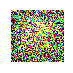

(0, 12288)
16
(16, 12288)
Iter: 1800
D loss: 0.6498
G_loss: 1.686
()


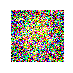

(0, 12288)
16
(16, 12288)
Iter: 1900
D loss: 0.3816
G_loss: 1.974
()


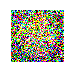

(0, 12288)
16
(16, 12288)
Iter: 2000
D loss: 0.5918
G_loss: 1.719
()


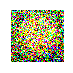

(0, 12288)
16
(16, 12288)
Iter: 2100
D loss: 0.5311
G_loss: 1.764
()


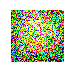

(0, 12288)
16
(16, 12288)
(0, 12288)
16
(16, 12288)
Iter: 2200
D loss: 0.8244
G_loss: 1.419
()


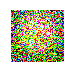

(0, 12288)
16
(16, 12288)
Iter: 2300
D loss: 0.7067
G_loss: 1.605
()


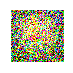

(0, 12288)
16
(16, 12288)
Iter: 2400
D loss: 0.8239
G_loss: 1.729
()


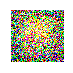

(0, 12288)
16
(16, 12288)
Iter: 2500
D loss: 0.7246
G_loss: 1.654
()


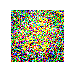

(0, 12288)
16
(16, 12288)
Iter: 2600
D loss: 1.111
G_loss: 1.248
()


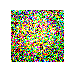

(0, 12288)
16
(16, 12288)
(0, 12288)
16
(16, 12288)
Iter: 2700
D loss: 0.9125
G_loss: 1.391
()


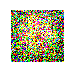

(0, 12288)
16
(16, 12288)
Iter: 2800
D loss: 0.839
G_loss: 1.301
()


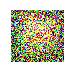

(0, 12288)
16
(16, 12288)
Iter: 2900
D loss: 0.6999
G_loss: 1.644
()


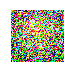

(0, 12288)
16
(16, 12288)
Iter: 3000
D loss: 0.4919
G_loss: 1.737
()


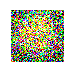

(0, 12288)
16
(16, 12288)
Iter: 3100
D loss: 0.4875
G_loss: 1.937
()


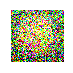

(0, 12288)
16
(16, 12288)
(0, 12288)
16
(16, 12288)
Iter: 3200
D loss: 0.5997
G_loss: 1.809
()


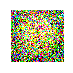

(0, 12288)
16
(16, 12288)
Iter: 3300
D loss: 0.6109
G_loss: 1.64
()


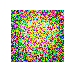

(0, 12288)
16
(16, 12288)
Iter: 3400
D loss: 0.7113
G_loss: 1.518
()


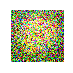

(0, 12288)
16
(16, 12288)
Iter: 3500
D loss: 1.21
G_loss: 0.9463
()


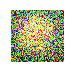

(0, 12288)
16
(16, 12288)
Iter: 3600
D loss: 0.9364
G_loss: 1.407
()


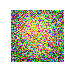

(0, 12288)
16
(16, 12288)
(0, 12288)
16
(16, 12288)
Iter: 3700
D loss: 0.8066
G_loss: 1.435
()


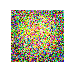

(0, 12288)
16
(16, 12288)
Iter: 3800
D loss: 1.183
G_loss: 1.181
()


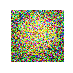

(0, 12288)
16
(16, 12288)
Iter: 3900
D loss: 0.762
G_loss: 1.527
()


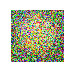

(0, 12288)
16
(16, 12288)
Iter: 4000
D loss: 0.6987
G_loss: 1.404
()


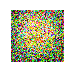

(0, 12288)
16
(16, 12288)
Iter: 4100
D loss: 0.8367
G_loss: 1.375
()


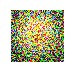

(0, 12288)
16
(16, 12288)
Iter: 4200
D loss: 1.084
G_loss: 1.075
()


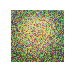

(0, 12288)
16
(16, 12288)
(0, 12288)
16
(16, 12288)
Iter: 4300
D loss: 0.8415
G_loss: 1.366
()


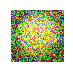

(0, 12288)
16
(16, 12288)
Iter: 4400
D loss: 0.8762
G_loss: 1.244
()


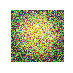

(0, 12288)
16
(16, 12288)
Iter: 4500
D loss: 0.8616
G_loss: 1.309
()


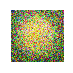

(0, 12288)
16
(16, 12288)
Iter: 4600
D loss: 1.342
G_loss: 1.104
()


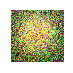

(0, 12288)
16
(16, 12288)
Iter: 4700
D loss: 0.9946
G_loss: 1.118
()


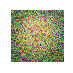

(0, 12288)
16
(16, 12288)
(0, 12288)
16
(16, 12288)
Iter: 4800
D loss: 1.224
G_loss: 0.874
()


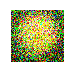

(0, 12288)
16
(16, 12288)
Iter: 4900
D loss: 1.183
G_loss: 1.088
()


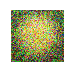

(0, 12288)
16
(16, 12288)


In [36]:
Z_dim = 100
first = 0

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())

D_loss_c = []
G_loss_c = []

for it in range(5000):
    if (first+mb_size <= len(X)) :
        x_input = X[first: first+mb_size, ]
    else :
        x_input = X[first: len(X), ]
        print x_input.shape
        first = (first + mb_size) % len(X)
        print first
        x_input = np.append(x_input, X[0: first, ]).reshape([-1, 12288])
        print x_input.shape
    
    first += mb_size

    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X_ph: x_input, Z_ph: sample_Z(mb_size, Z_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z_ph: sample_Z(mb_size, Z_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z_ph: sample_Z(mb_size, Z_dim)})
    
    if it % 100 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()
        D_loss_c.append(D_loss_curr)
        G_loss_c.append(G_loss_curr)
    if it % 100 == 0:
        samples = sess.run(G_sample, feed_dict={Z_ph: sample_Z(1, Z_dim)})
        fig = plot(samples)
        #plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        plt.show(fig)

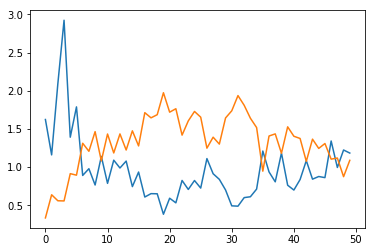

In [37]:
plt.plot(D_loss_c)
plt.plot(G_loss_c)
plt.show()